<a href="https://colab.research.google.com/github/bhkpriyanka/EIP4/blob/master/Session5/PersonAttributes_ResnetArchitecture_lr0_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/Session5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from matplotlib import pyplot as plt
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.regularizers import l2
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os
from keras.callbacks import TensorBoard,ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
df.iloc[876]

gender                         male
imagequality                   Good
age                           25-35
weight          slightly-overweight
carryingbag                    None
footwear                    CantSee
emotion                       Happy
bodypose             Front-Frontish
image_path          resized/877.jpg
Name: 876, dtype: object

(224, 224, 3)


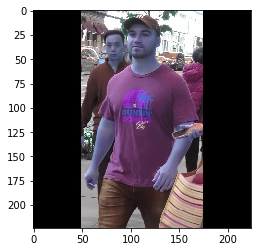

In [5]:

x = cv2.imread(df.image_path[876])
print(x.shape)
plt.imshow(x)
plt.show()

In [6]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation =None, subtract_pixel_mean=False):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        self.subtract_pixel_mean = subtract_pixel_mean

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        
        # If subtract pixel mean is enabled
        '''if self.subtract_pixel_mean:
          mean = []
          std  = []
          for i in range(image.shape[-1]):
            pixels = image[:, :, :, i].ravel()
            mean.append(np.mean(pixels))
            std.append(np.std(pixels))'''

        if self.augmentation is not None:
                 image = self.augmentation.flow(image,shuffle = False).next()

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [8]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state =1)
train_df.shape, val_df.shape




((11537, 28), (2036, 28))

In [9]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
58,resized/59.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2106,resized/2107.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
5206,resized/5207.jpg,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
1163,resized/1164.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
13534,resized/13536.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32,subtract_pixel_mean=False,
                            augmentation = ImageDataGenerator(horizontal_flip = True,rotation_range = 20, zoom_range = 0.2 ))
                                                          
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False, subtract_pixel_mean=False)

    

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

https://d2l.ai/chapter_convolutional-modern/resnet.html

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.005
    if epoch > 120:
        lr *= 0.5e-3
    elif epoch > 100:
        lr *= 1e-2
    elif epoch > 60:
        lr *= 1e-1
    elif epoch > 40:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr

In [0]:
n = 2
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 5 + 2
    

In [0]:

def resnet_layer(inputs,
                 num_filters=32,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')
                  #kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth):
       
    if (depth - 2) % 5!= 0:
        raise ValueError('depth should be 4n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 32
    num_res_blocks = int((depth - 2) / 5)

    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(5):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    output = AveragePooling2D(pool_size=2)(x)
    #y = Flatten()(x)
    '''outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)'''

    # Instantiate model.
    model = Model(inputs=inputs, outputs=output)
    return model

In [16]:
backbone = resnet_v1(input_shape= (224,224,3), depth=depth)

neck = backbone.output
neck = GlobalAveragePooling2D()(neck)
#neck = Flatten(name="flatten")(neck)
#neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    #neck = Dropout(0.3)(in_layer)
    #neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
opt = SGD(lr=lr_schedule(80), momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()
model_type= "resnet"

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'PA_%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Learning rate:  0.0005


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None,

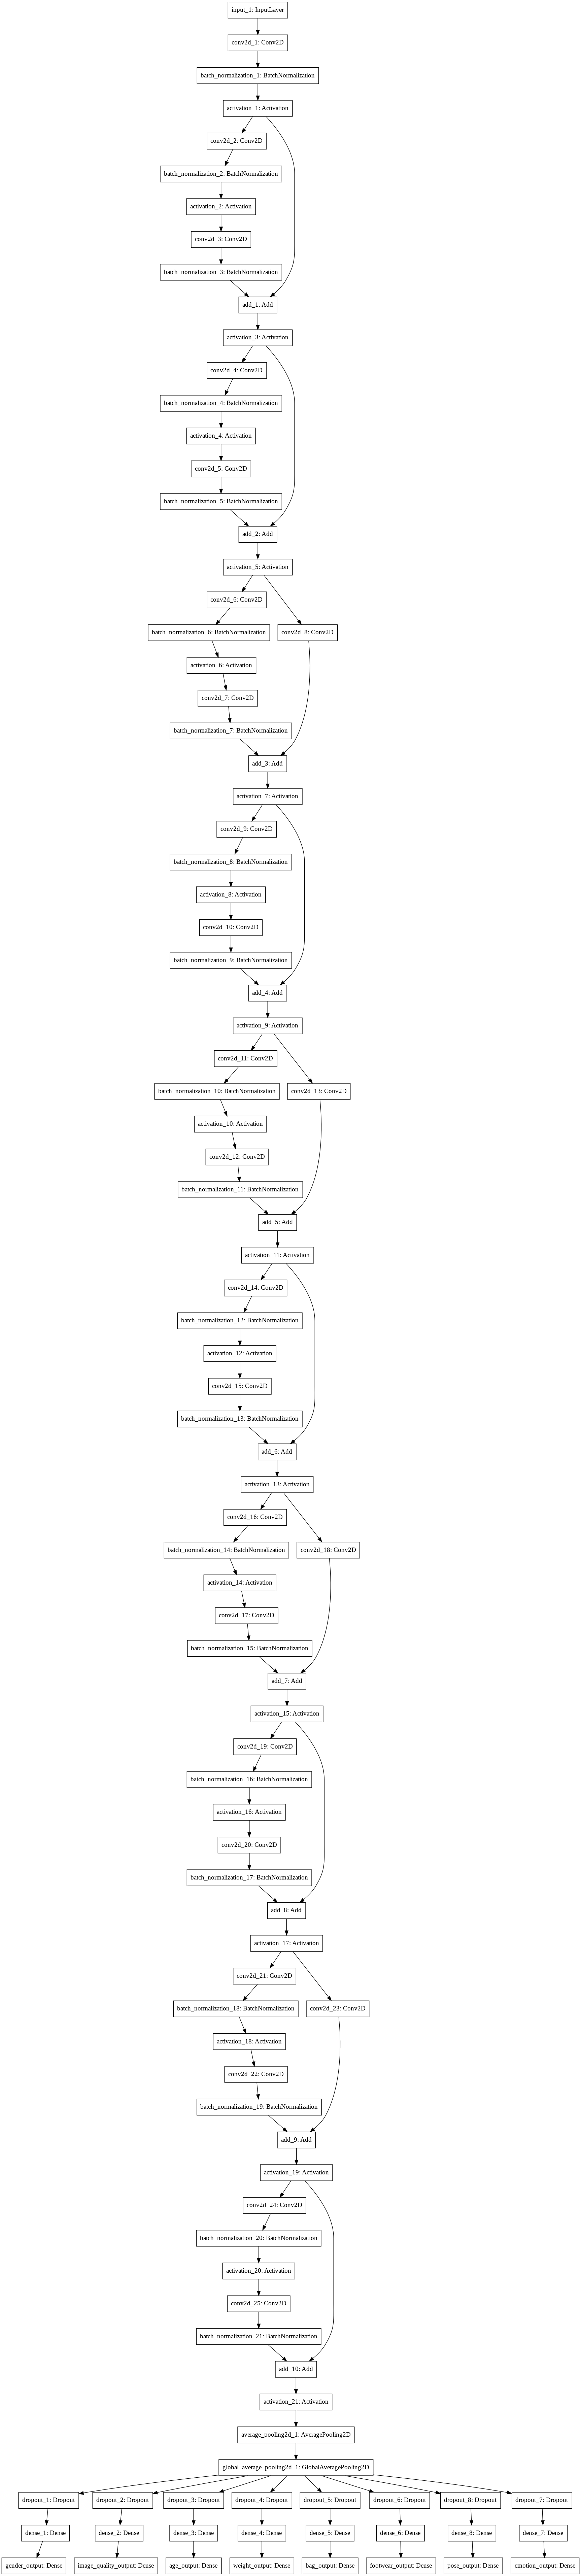

In [17]:
from keras.utils import plot_model
plot_model(model)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.3,
                               cooldown=0,
                               patience=5,
                               min_lr=1e-4)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,update_freq= 'epoch',
                          write_graph=True, write_images=False)                             

callbacks = [checkpoint, lr_scheduler,lr_reducer,tensorboard]

In [0]:
results= model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=80,
    verbose=2,
    callbacks=callbacks)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/80
Learning rate:  0.005
 - 328s - loss: 8.0541 - gender_output_loss: 0.7146 - image_quality_output_loss: 0.9964 - age_output_loss: 1.4614 - weight_output_loss: 1.0249 - bag_output_loss: 0.9458 - footwear_output_loss: 1.0143 - pose_output_loss: 0.9526 - emotion_output_loss: 0.9441 - gender_output_acc: 0.5676 - image_quality_output_acc: 0.5458 - age_output_acc: 0.3929 - weight_output_acc: 0.6294 - bag_output_acc: 0.5602 - footwear_output_acc: 0.5050 - pose_output_acc: 0.6115 - emotion_output_acc: 0.7122 - val_loss: 7.9057 - val_gender_output_loss: 0.6854 - val_image_quality_output_loss: 0.9755 - val_age_output_loss: 1.4467 - val_weight_output_loss: 0.9917 - val_bag_output_loss: 0.9353 - val_footwear_output_loss: 0.9768 - val_pose_output_loss: 0.9283 - val_emotion_output_loss: 0.9661 - val_gender_output_acc: 0.5615 - val_image_quality_output_acc: 0.5481 - val_age_output_acc: 0.3666 -

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 312s - loss: 7.7251 - gender_output_loss: 0.6615 - image_quality_output_loss: 0.9562 - age_output_loss: 1.4170 - weight_output_loss: 0.9876 - bag_output_loss: 0.9071 - footwear_output_loss: 0.9609 - pose_output_loss: 0.9298 - emotion_output_loss: 0.9050 - gender_output_acc: 0.6004 - image_quality_output_acc: 0.5527 - age_output_acc: 0.4043 - weight_output_acc: 0.6343 - bag_output_acc: 0.5670 - footwear_output_acc: 0.5464 - pose_output_acc: 0.6179 - emotion_output_acc: 0.7160 - val_loss: 7.8711 - val_gender_output_loss: 0.6716 - val_image_quality_output_loss: 0.9388 - val_age_output_loss: 1.4850 - val_weight_output_loss: 0.9813 - val_bag_output_loss: 0.9279 - val_footwear_output_loss: 0.9814 - val_pose_output_loss: 0.9251 - val_emotion_output_loss: 0.9600 - val_gender_output_acc: 0.5754 - val_image_quality_output_acc: 0.5551 - val_age_output_acc: 0.3656 - val_weight_output_acc: 0.6399 - val_bag_output_acc: 0.5471 - val_footwear_output_acc: 0.5362 - val_pose_output_acc: 0.6146 - val_e

In [0]:
'''
#Open Terminal in your working directory and type the command below.
tensorboard --logdir ./Graph
#Now open your web browser and enter the address below.
http://localhost:6006'''